#### Data set

This dataset contains information about employees who worked in a company.

### Task

Make an analysis and build a model that can determine with a high probability whether an employee will leave the company.


### Data set description

In this [dataset](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv), there are 14,999 rows, 10 columns, and these variables: 

Variable  |Description |
-----|-----| 
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

## Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import  f1_score, precision_score
from sklearn.model_selection import RandomizedSearchCV

import pickle
import sys

### Load dataset

In [7]:
# Load dataset into a dataframe
df = pd.read_csv("HR_comma_sep.csv")

# Display first few rows of the dataframe
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Data Exploration

In [8]:
# Gather basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Descriptive statistics about the data

In [9]:
# Gather descriptive statistics about the data
df.describe(include='all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999,14999
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4140,7316
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


In [10]:
df.promotion_last_5years.value_counts()

0    14680
1      319
Name: promotion_last_5years, dtype: int64

In [11]:
df.left.value_counts()

0    11428
1     3571
Name: left, dtype: int64

In [12]:
df.Work_accident.value_counts()

0    12830
1     2169
Name: Work_accident, dtype: int64

### Rename columns

In [13]:
# Rename columns as needed
df = df.rename(columns={'Work_accident': 'work_accident',
                          'Department': 'department'})

### Check missing values

In [14]:
# Check for missing values
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

### Check duplicates

Check for any duplicate entries in the data.

In [15]:
# Check for duplicates
print(f'Number of dupclicaded rows: {df.duplicated().sum()}')

Number of dupclicaded rows: 3008


In [16]:
# Drop duplicates
df = df.drop_duplicates(keep='first')

In [17]:
df.shape

(11991, 10)

In [18]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Conver columns with 0 and 1 to column with False and True

In [19]:
for column in df.columns:
    if len(df[column].value_counts()) == 2 and df[column].index[0] in  [0, 1] and df[column].index[1] in [0, 1]:
        df[column] = df[column].apply(lambda x: True if x > 0 else False)

In [20]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,False,True,False,sales,low
1,0.80,0.86,5,262,6,False,True,False,sales,medium
2,0.11,0.88,7,272,4,False,True,False,sales,medium
3,0.72,0.87,5,223,5,False,True,False,sales,low
4,0.37,0.52,2,159,3,False,True,False,sales,low


### Check outliers

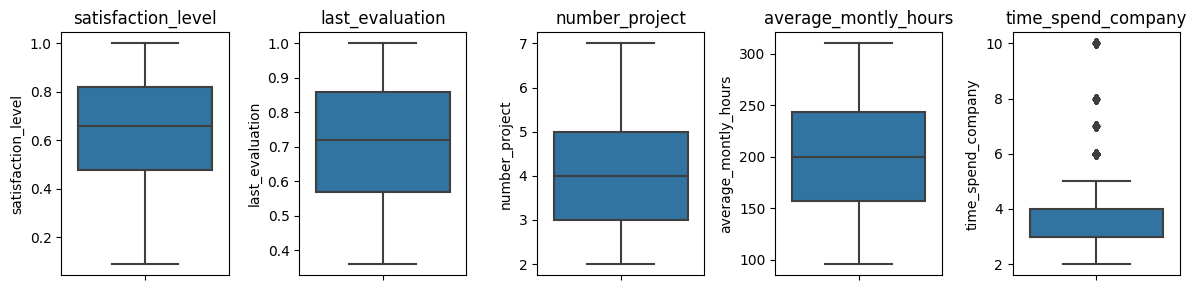

In [21]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 3))  

for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

Outliers are in the time_spend_company column

In [22]:
def count_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return ((column < lower_bound) | (column > upper_bound)).sum()

In [23]:
print(f'Number of outliers in the time_spend_company column : {count_outliers(df.time_spend_company)}')

Number of outliers in the time_spend_company column : 824


### EDA

#### Boolean columns analysis

boolean columns:  work_accident left promotion_last_5years


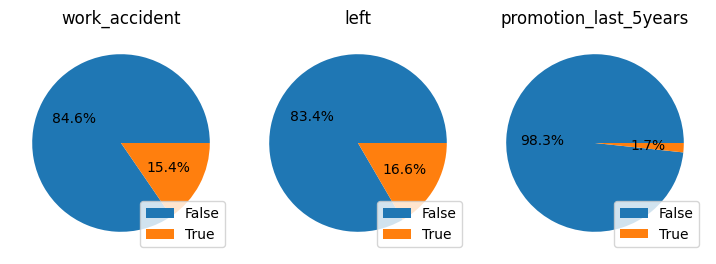

In [24]:
boolean_cols = df.select_dtypes(include=['boolean']).columns
print('boolean columns: ', *boolean_cols)
plt.figure(figsize=(12, 3))  
for i, col in enumerate(boolean_cols, 1):
    plt.subplot(1, len(num_cols), i)
    plt.pie(df[col].value_counts(), autopct='%1.1f%%')
    plt.title(col)
    plt.legend(df[col].value_counts().index, loc='lower right')

plt.tight_layout()
plt.show()


Percantage in boolean columns

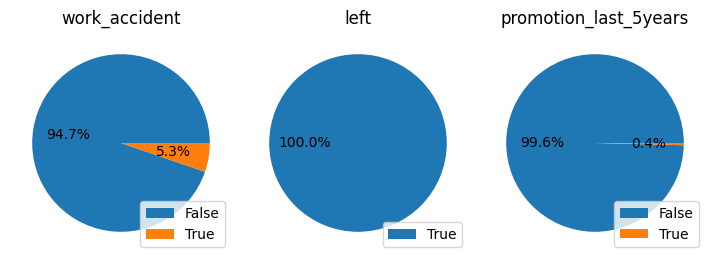

In [25]:
df_left = df[df['left'] == True]
plt.figure(figsize=(12, 3))  
for i, col in enumerate(boolean_cols, 1):
    plt.subplot(1, len(num_cols), i)
    plt.pie(df_left[col].value_counts(), autopct='%1.1f%%')
    plt.title(col)
    plt.legend(df_left[col].value_counts().index, loc='lower right')
plt.tight_layout()
plt.show()

Employees who left the company

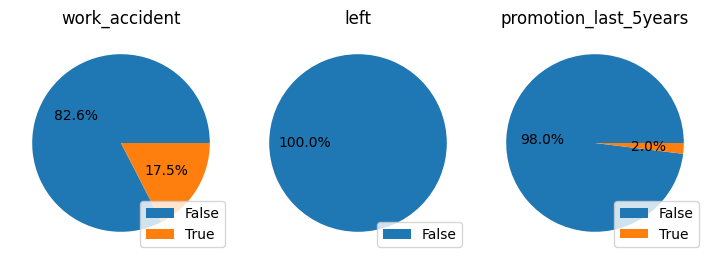

In [26]:
df_stayed = df[df['left'] == False]
plt.figure(figsize=(12, 3))  
for i, col in enumerate(boolean_cols, 1):
    plt.subplot(1, len(num_cols), i)
    plt.pie(df_stayed[col].value_counts(), autopct='%1.1f%%')
    plt.title(col)
    plt.legend(df_stayed[col].value_counts().index, loc='lower right')

plt.tight_layout()
plt.show()

Employees who stayed in the company

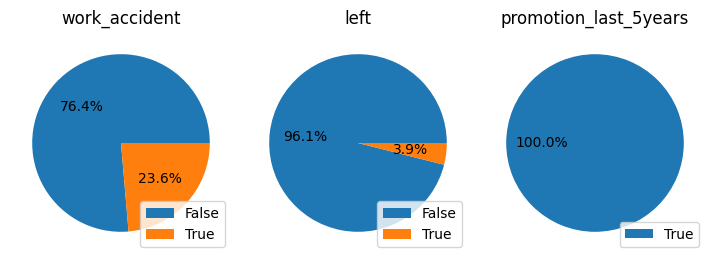

In [27]:
df_promoted = df[df['promotion_last_5years'] == True]
plt.figure(figsize=(12, 3))  
for i, col in enumerate(boolean_cols, 1):
    plt.subplot(1, len(num_cols), i)
    plt.pie(df_promoted[col].value_counts(), autopct='%1.1f%%')
    plt.title(col)
    plt.legend(df_promoted[col].value_counts().index, loc='lower right')

plt.tight_layout()
plt.show()

Employees who was promoted in the last 5 years

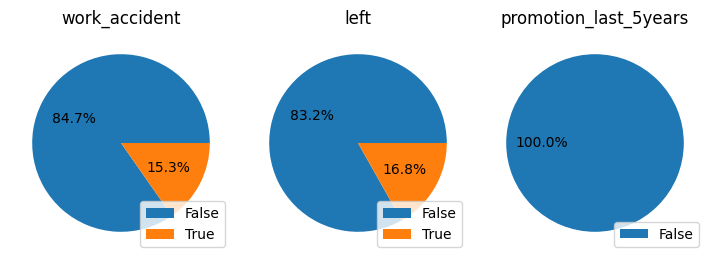

In [28]:
df_not_promoted = df[df['promotion_last_5years'] == False]
plt.figure(figsize=(12, 3))  
for i, col in enumerate(boolean_cols, 1):
    plt.subplot(1, len(num_cols), i)
    plt.pie(df_not_promoted[col].value_counts(), autopct='%1.1f%%')
    plt.title(col)
    plt.legend(df_not_promoted[col].value_counts().index, loc='lower right')

plt.tight_layout()
plt.show()

Employees who wasn't promoted in the last 5 years

#### Numerical columns analysis

array([[<Axes: title={'center': 'satisfaction_level'}>,
        <Axes: title={'center': 'last_evaluation'}>],
       [<Axes: title={'center': 'number_project'}>,
        <Axes: title={'center': 'average_montly_hours'}>],
       [<Axes: title={'center': 'time_spend_company'}>, <Axes: >]],
      dtype=object)

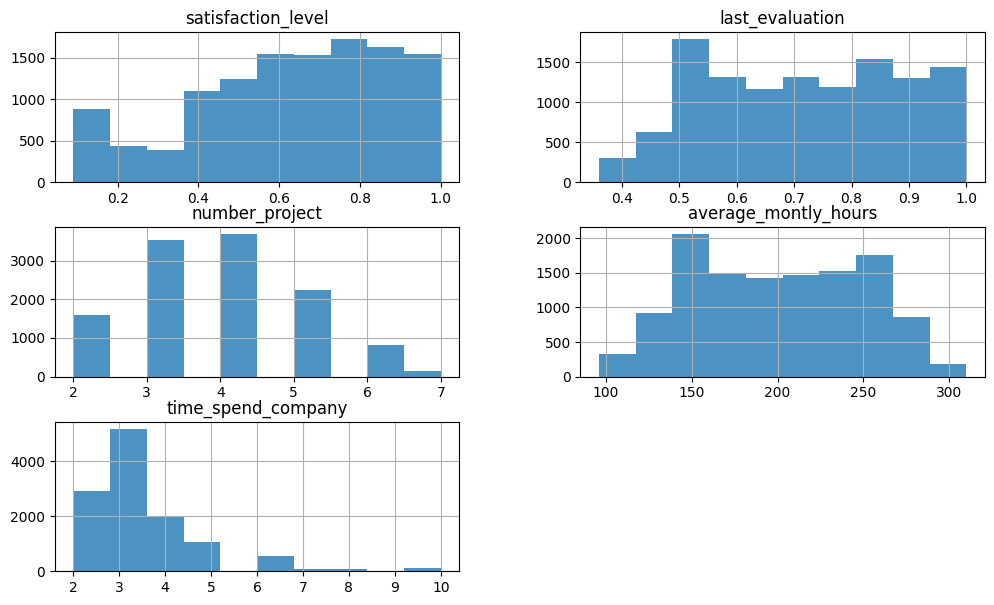

In [29]:
df.hist(alpha=0.8, figsize=(12, 7))

Distribution of the numerical columns

array([[<Axes: title={'center': 'satisfaction_level'}>,
        <Axes: title={'center': 'last_evaluation'}>],
       [<Axes: title={'center': 'number_project'}>,
        <Axes: title={'center': 'average_montly_hours'}>],
       [<Axes: title={'center': 'time_spend_company'}>, <Axes: >]],
      dtype=object)

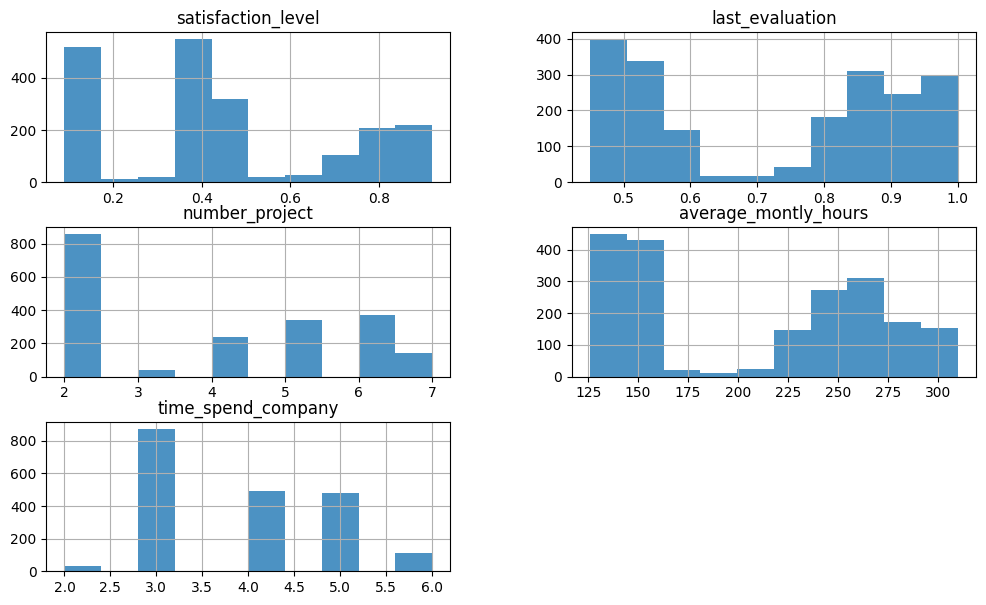

In [30]:
df_left.hist(alpha=0.8, figsize=(12, 7))

Distribution of the numerical columns for employees who left

array([[<Axes: title={'center': 'satisfaction_level'}>,
        <Axes: title={'center': 'last_evaluation'}>],
       [<Axes: title={'center': 'number_project'}>,
        <Axes: title={'center': 'average_montly_hours'}>],
       [<Axes: title={'center': 'time_spend_company'}>, <Axes: >]],
      dtype=object)

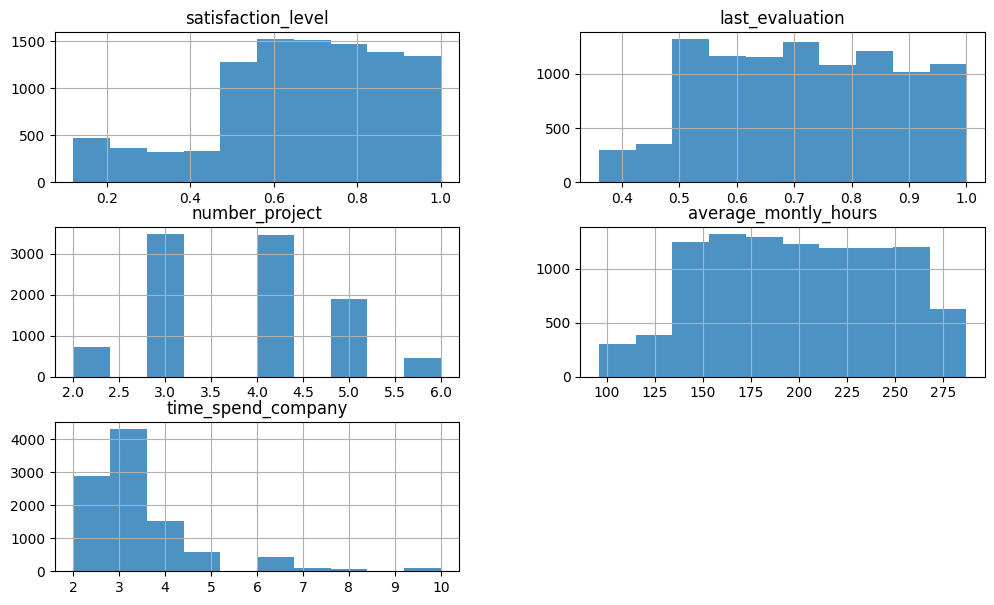

In [31]:
df_stayed.hist(alpha=0.8, figsize=(12, 7))

Distribution of the numerical columns for employees who stayed

Number of the projects analysis

In [32]:
print(f"Number of retired employers with more than 6 projects: {df[(df['number_project'] > 6) &(df['left'] == True)].shape[0]}")
print(f"Number of stayed employers with more than 6 projects: {df[(df['number_project'] > 6) &(df['left'] == False)].shape[0]}")

Number of retired employers with more than 6 projects: 145
Number of stayed employers with more than 6 projects: 0


Average monthly hours analysis

In [33]:
print(f"Number of retired employers with more than 287 average monthly working hours: {df[(df['average_montly_hours'] > 287) &(df['left'] == True)].shape[0]}")
print(f"Number of stayed employers with more than 287 average monthly working hours: {df[(df['average_montly_hours'] > 287) &(df['left'] == False)].shape[0]}")

Number of retired employers with more than 287 average monthly working hours: 184
Number of stayed employers with more than 287 average monthly working hours: 0


Time spend company analysis

In [34]:
print(f"Number of retired employers with more than 6 years in the company: {df[(df['time_spend_company'] > 6) &(df['left'] == True)].shape[0]}")
print(f"Number of retired employers with more than 6 years in the company: {df[(df['time_spend_company'] > 6) &(df['left'] == False)].shape[0]}")

Number of retired employers with more than 6 years in the company: 0
Number of retired employers with more than 6 years in the company: 282


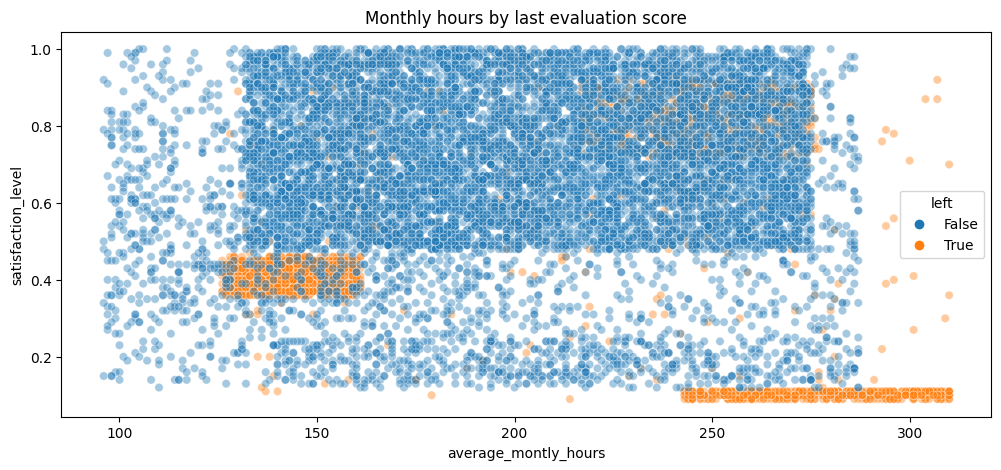

In [35]:
# Create scatterplot of `average_montly_hours` versus `satisfaction_level`, comparing employees who stayed versus those who left
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df, x='average_montly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.title('Monthly hours by last evaluation score')
plt.show()

#### Categorical columns analysis

In [36]:
# Display counts for each salary level

df.salary.value_counts()

low       5740
medium    5261
high       990
Name: salary, dtype: int64

In [37]:
# Display counts for each department

df.department.value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

Text(0.5, 1.0, 'Counts of stayed/left by department')

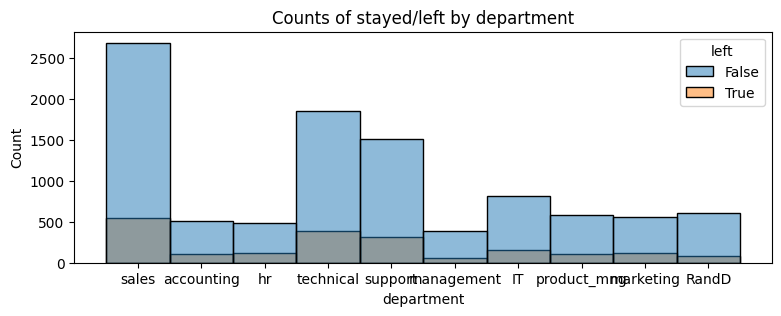

In [38]:
# Create stacked histogram to compare department distribution of employees who left to that of employees who didn't
plt.figure(figsize=(9, 3))
sns.histplot(data=df, x='department', hue='left')
plt.title('Counts of stayed/left by department')


There doesn't seem to be any department that differs significantly in its proportion of employees who left to those who stayed. 

Text(0.5, 1.0, 'Counts of stayed/left by department')

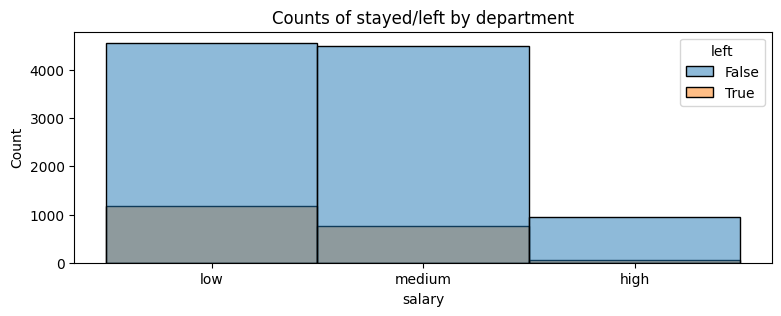

In [39]:
# Create stacked histogram to compare department distribution of employees who left to that of employees who didn't
plt.figure(figsize=(9, 3))
sns.histplot(data=df, x='salary', hue='left')
plt.title('Counts of stayed/left by department')


There doesn't seem to be any salary level that differs significantly in its proportion of employees who left to those who stayed. 

<Figure size 1200x500 with 0 Axes>

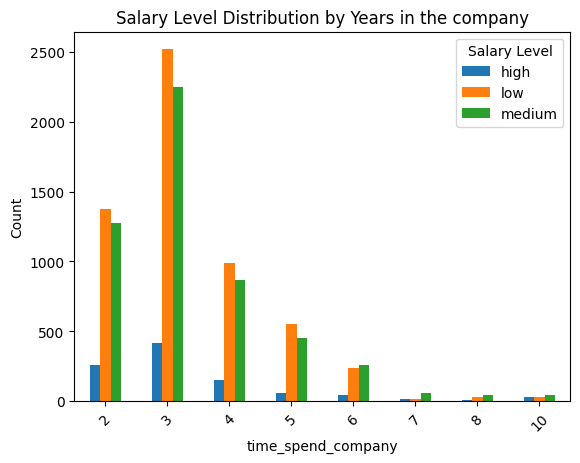

In [40]:
years_salary_grouped = df.groupby(['time_spend_company', 'salary']).size().unstack()
plt.figure(figsize=(12, 5))
years_salary_grouped.plot(kind='bar')
plt.xlabel('time_spend_company')
plt.ylabel('Count')
plt.title('Salary Level Distribution by Years in the company')
plt.legend(title='Salary Level')
plt.xticks(rotation=45)
plt.show()

<Figure size 1400x500 with 0 Axes>

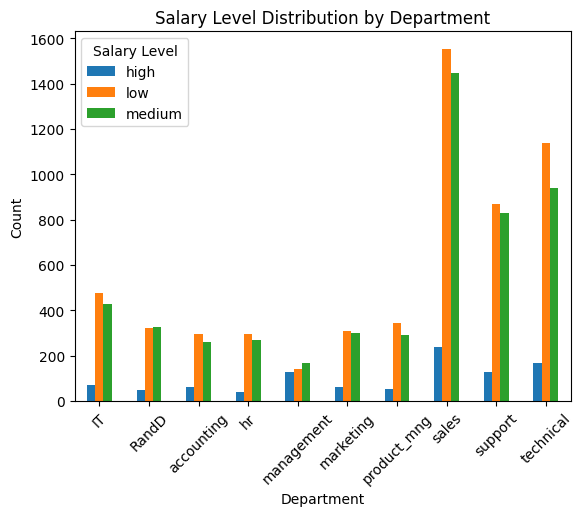

In [41]:
dep_salary_grouped = df.groupby(['department', 'salary']).size().unstack()
plt.figure(figsize=(14, 5))
dep_salary_grouped.plot(kind='bar')
plt.xlabel('Department')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Salary Level Distribution by Department')
plt.legend(title='Salary Level')
plt.show()

Tenure Vs Satisfaction and Promotion

In [116]:
# Groupping data by time_spend_company column

df_satisf_promoted = df[df['promotion_last_5years']==True].groupby('time_spend_company')['satisfaction_level'].mean()
df_satisf_not_promoted = df[df['promotion_last_5years']==False].groupby('time_spend_company')['satisfaction_level'].mean()

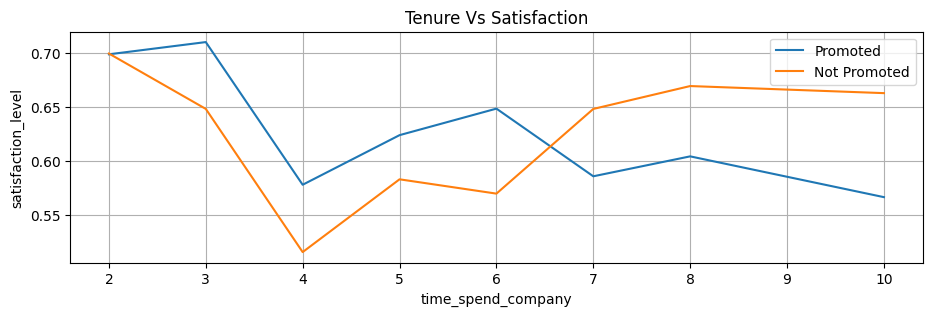

In [115]:
plt.figure(figsize=(11, 3))
sns.lineplot(df_satisf_promoted, label='Promoted')
sns.lineplot(df_satisf_not_promoted, label='Not Promoted')
plt.title('Tenure Vs Satisfaction')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\voken\AppData\Local\Temp\ipykernel_24268\1348806634.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))


Text(0.5, 1.0, 'Correlation Heatmap')

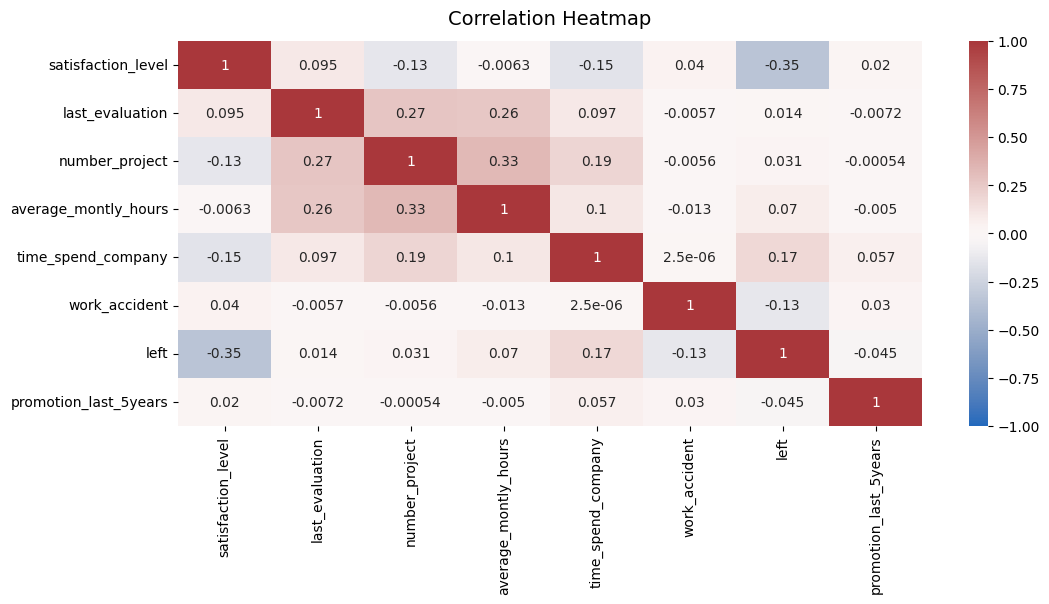

In [42]:
# Plot a correlation heatmap
plt.figure(figsize=(12, 5))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)

The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores all correlate positively with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

## Model Building

Plan:
- Building few different classification models.
- Evaluate with appropriate metrics
- Fine tune the best model

For prediction, two approaches are used:
- Make predictions on current data
- Make predictions on data with new features

In [43]:
for column in df.columns:
    if len(df[column].value_counts()) == 2 and df[column].index[0] in  [True, False] and df[column].index[1] in [True, False]:
        df[column] = df[column].apply(lambda x: 1 if x else 0)

In [45]:
X = df.drop(columns=['left'],axis=1)
y = df['left']

In [46]:
# Create the list of categorical columns

cat_features = X.select_dtypes(include="object").columns

In [47]:
# Encoding categorical columns

X = pd.get_dummies(X, columns=cat_features)

In [48]:
# Separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(f'X_train, X_test = {X_train.shape, X_test.shape}')

X_train, X_test = ((9592, 20), (2399, 20))


Create an evaluation function to give all metrics after model Training

In [49]:
def evaluate_model(true, predicted):
    precision = precision_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    f1 = f1_score(true, predicted)
    return precision, roc_auc, f1

In [50]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Trees": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "LightGBM": lgb.LGBMClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
}

Prepare lists for results

In [51]:
model_list = []
precision_list = []
roc_auc_list = []
f1_list = []

In [52]:
%%time
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit (X_train, y_train) 

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_precision, model_train_roc_auc, model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_test_precision, model_test_roc_auc, model_test_f1 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Precision score: {:.4f}".format(model_train_precision))
    print("- ROC AUC Score: {:.4f}".format(model_train_roc_auc))
    print("- f1 Score: {:.4f}".format(model_train_f1))
    print('----------------------------------')
    print('Model performance for Test set')
    print("- Precision score: {:.4f}".format(model_test_precision))
    print("- ROC AUC Score: {:.4f}".format(model_test_roc_auc))
    print("- f1 Score: {:.4f}".format(model_test_f1))

    precision_list.append(model_test_precision)
    roc_auc_list.append(model_test_roc_auc)
    f1_list.append(model_test_f1)
    print('='*35)
    print('\n')


Logistic Regression
Model performance for Training set
- Precision score: 0.4937
- ROC AUC Score: 0.5786
- f1 Score: 0.2821
----------------------------------
Model performance for Test set
- Precision score: 0.4815
- ROC AUC Score: 0.5635
- f1 Score: 0.2425


Decision Trees
Model performance for Training set
- Precision score: 1.0000
- ROC AUC Score: 1.0000
- f1 Score: 1.0000
----------------------------------
Model performance for Test set
- Precision score: 0.8814
- ROC AUC Score: 0.9416
- f1 Score: 0.8943




C:\Users\voken\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest
Model performance for Training set
- Precision score: 1.0000
- ROC AUC Score: 1.0000
- f1 Score: 1.0000
----------------------------------
Model performance for Test set
- Precision score: 0.9757
- ROC AUC Score: 0.9479
- f1 Score: 0.9364


Gradient Boosting
Model performance for Training set
- Precision score: 0.9661
- ROC AUC Score: 0.9628
- f1 Score: 0.9488
----------------------------------
Model performance for Test set
- Precision score: 0.9630
- ROC AUC Score: 0.9504
- f1 Score: 0.9345


XGBoost
Model performance for Training set
- Precision score: 0.9974
- ROC AUC Score: 0.9894
- f1 Score: 0.9883
----------------------------------
Model performance for Test set
- Precision score: 0.9678
- ROC AUC Score: 0.9471
- f1 Score: 0.9328


[LightGBM] [Info] Number of positive: 1590, number of negative: 8002
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And

C:\Users\voken\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\voken\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


LightGBM
Model performance for Training set
- Precision score: 0.9968
- ROC AUC Score: 0.9874
- f1 Score: 0.9860
----------------------------------
Model performance for Test set
- Precision score: 0.9784
- ROC AUC Score: 0.9506
- f1 Score: 0.9404


K-Nearest Neighbors
Model performance for Training set
- Precision score: 0.8463
- ROC AUC Score: 0.9422
- f1 Score: 0.8805
----------------------------------
Model performance for Test set
- Precision score: 0.8078
- ROC AUC Score: 0.9191
- f1 Score: 0.8425


Linear Discriminant Analysis
Model performance for Training set
- Precision score: 0.4909
- ROC AUC Score: 0.6011
- f1 Score: 0.3354
----------------------------------
Model performance for Test set
- Precision score: 0.4973
- ROC AUC Score: 0.5904
- f1 Score: 0.3116


CPU times: total: 6.06 s
Wall time: 3.46 s


In [53]:
# Create data set with results

models_results = pd.DataFrame(list(zip(model_list, f1_list, roc_auc_list, precision_list)), columns=['Model Name', 'f1_score', 'roc_auc_score', 'precision_score'])
models_results = models_results.sort_values(by=['f1_score'], ascending=False)

In [54]:
models_results

,Model Name,f1_score,roc_auc_score,precision_score
5,LightGBM,0.940415,0.950616,0.978437
2,Random Forest,0.936446,0.947872,0.975676
3,Gradient Boosting,0.934531,0.950362,0.962963
4,XGBoost,0.932817,0.947122,0.967828
1,Decision Trees,0.894349,0.941603,0.881356
6,K-Nearest Neighbors,0.842482,0.919129,0.807780
7,Linear Discriminant Analysis,0.311644,0.590443,0.497268
0,Logistic Regression,0.242537,0.563530,0.481481


#### Fine tunning top 2 best models

LightGBM

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40],
    'num_leaves': [31, 50],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['binary'],
    'metric': ['auc'],
    'feature_fraction': [0.8, 0.9],
    'bagging_fraction': [0.8, 0.9],
    'bagging_freq': [5, 10],
    'lambda_l1': [0, 1],
    'lambda_l2': [0, 1]
}

clf = lgb.LGBMClassifier()
grid = GridSearchCV(clf, param_grid, verbose=1, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print(f'Best parameters found by grid search are: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

In [56]:
best_params_lightgbm = grid.best_params_
clf_lgbm = lgb.LGBMClassifier(**best_params_lightgbm)
clf_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM]

LGBMClassifier(bagging_fraction=0.9, bagging_freq=10, feature_fraction=0.9,
               lambda_l1=0, lambda_l2=1, metric='auc', n_estimators=40,
               num_leaves=50, objective='binary')

In [57]:
# Check LightGBM fine tunning results

y_test_pred = clf_lgbm.predict(X_test)
model_test_precision, model_test_roc_auc, model_test_f1 = evaluate_model(y_test, y_test_pred)
print(f'''
Precision score: {model_test_precision}
ROC AUC score: {model_test_roc_auc}
f1 score: {model_test_f1}
''')

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Precision score: 0.978319783197832
ROC AUC score: 0.9481226862772997
f1 score: 0.9376623376623378



Random Forest

In [58]:
# Random Forest

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid, verbose=1, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print(f'Best parameters found by grid search are: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


Best parameters found by grid search are: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best score: 0.9856130105296627


In [59]:
best_params_rf = grid.best_params_
clf_rf = RandomForestClassifier(**best_params_rf)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, min_samples_split=5, n_estimators=200)

In [60]:
# Check Random Forest fine tunning results

y_test_pred = clf_rf.predict(X_test)
model_test_precision, model_test_roc_auc, model_test_f1 = evaluate_model(y_test, y_test_pred)
print(f'''
Precision score: {model_test_precision}
ROC AUC score: {model_test_roc_auc}
f1 score: {model_test_f1}
''')


Precision score: 0.9756756756756757
ROC AUC score: 0.9478724360270495
f1 score: 0.9364461738002594



### Feature Importance

LightGBM

<Axes: title={'center': 'Feature importance for LightGBM'}, xlabel='Feature importance', ylabel='Features'>

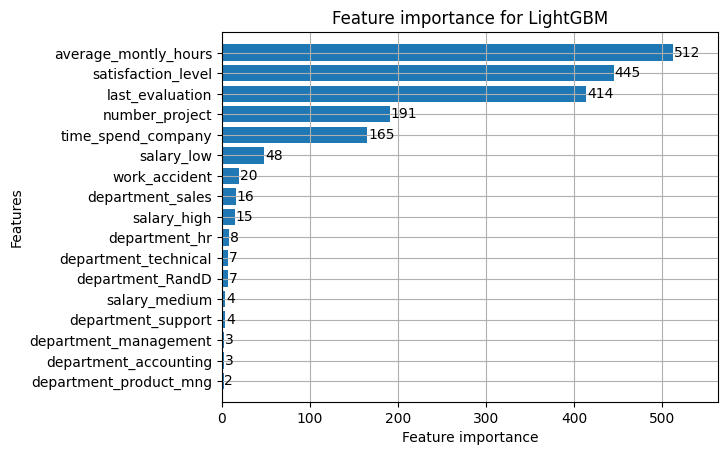

In [61]:
lgb.plot_importance(clf_lgbm, height=0.8, title='Feature importance for LightGBM',\
     xlabel='Feature importance', ylabel='Features', importance_type='auto', ignore_zero=True,  grid=True)

Random Forest

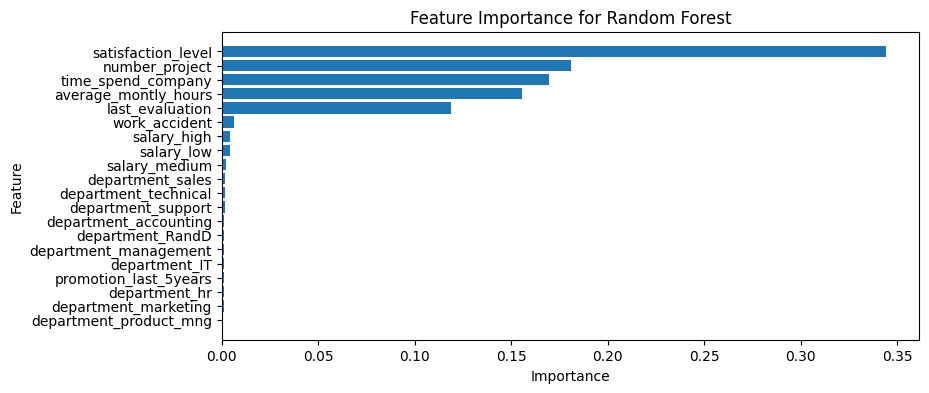

In [62]:
# Create new df with feature importaces
importance_rf = clf_rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_rf
})

#Sort values
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

#Plot graph
plt.figure(figsize=(9, 4))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest')
plt.gca().invert_yaxis()
plt.show()

Key feature for Random Forest Model:
- Satisfaction level

Key features for LightGBM Model:
- Average Monthly hours

#### Build Confusion Matrix to check how model performs and choose the winner

LightFBM Confusion Matrix

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


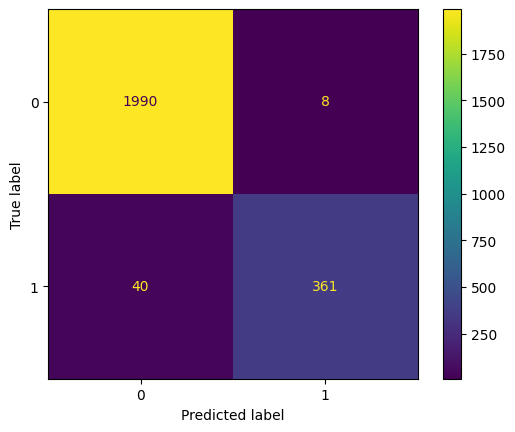

In [63]:
# Generate array of values for confusion matrix
y_test_pred_lgbm = clf_lgbm.predict(X_test)
cm_lgbm = confusion_matrix(y_test, y_test_pred_lgbm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm,
                             display_labels=clf_lgbm.classes_)
disp.plot()

Random Forest Confusion Matrix

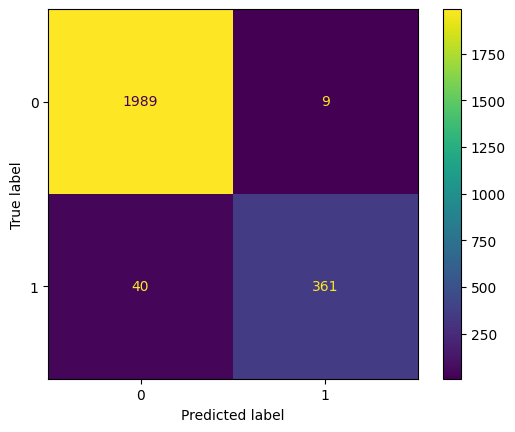

In [64]:
# Generate array of values for confusion matrix
y_test_pred = clf_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                             display_labels=clf_rf.classes_)
disp.plot()

A False Negative - is a situation where the model assumes that an employees will stay, but they are leaving. This means a missed opportunity for the company to retain an employees.
For LightGBM FN = 8
For Random Forest FN = 9

#### The winner is  LightGBM Model 

Specify path to where you want to save your model.

In [65]:
# Define a path to the folder where you want to save the model
path = 'D:\\Downloads\\capstone\\models\\'

Define functions to pickle the model and read in the model.

In [66]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path: path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as: filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [67]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path: path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

Use the functions defined above to save the model in a pickle file and then read it in.

In [68]:
# Write pickle
write_pickle(path, clf_rf, 'clf_rf')

In [69]:
# # Read pickle
# clf_rf = read_pickle(path, 'clf_rf')

### Feature Engineering

Add features to explore model performance

In [70]:
# Copy main dataset

df_fe = df.copy()

In [71]:
df_fe.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Break down the average number of hours into 3 categories: part-time, full-time and over-time

1 month = 4.33 weeks
full-time week is in the range 35-45 hours
Assume that:
- part-time < 152
- 152 > full-time > 195   
- over-time > 195
- super-over-time > 287

Find full-time monthly bounds

In [72]:
lower_bound = np.round(4.33 * 35)
print(lower_bound)

152.0


In [73]:
upper_bound = np.round(4.33 * 45)
print(upper_bound)

195.0


In [74]:
def num_prof_to_cat(value):
    '''
    function converts numerical average monthly work time value into categorical
    df: name of the data set
    '''
    if value < lower_bound:
        value = 'part_time'
    elif value > upper_bound and value  <= 287:
        value = 'over_time'
    elif value >  287:
        value = 'super_over_time'
    else:
        value = 'full_time'
        
    return value

In [75]:
df_fe['average_montly_hours'] = df_fe['average_montly_hours'].apply(num_prof_to_cat)

In [76]:
df_fe['average_montly_hours'].value_counts()

over_time          6088
full_time          3284
part_time          2435
super_over_time     184
Name: average_montly_hours, dtype: int64

Change number number_project from numerical to categorical column

In [77]:
df_fe['number_project'] = df_fe['number_project'].astype(str)

In [78]:
# Display first few rows of new dataframe

df_fe.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,full_time,3,0,1,0,sales,low
1,0.80,0.86,5,over_time,6,0,1,0,sales,medium
2,0.11,0.88,7,over_time,4,0,1,0,sales,medium
3,0.72,0.87,5,over_time,5,0,1,0,sales,low
4,0.37,0.52,2,full_time,3,0,1,0,sales,low


In [79]:
# Select the features
X_fe = df_fe.drop('left', axis=1)

# Isolate the outcome variable
y_fe = df_fe['left']

# Create the list of categorical columns
cat_features_fe = X_fe.select_dtypes(include="object").columns

# Categorical columns encoding
X_fe = pd.get_dummies(X_fe, columns=cat_features_fe)

In [117]:
X_fe.head()

,satisfaction_level,last_evaluation,time_spend_company,work_accident,promotion_last_5years,number_project_2,number_project_3,number_project_4,number_project_5,number_project_6,number_project_7,average_montly_hours_full_time,average_montly_hours_over_time,average_montly_hours_part_time,average_montly_hours_super_over_time,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,6,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,4,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


Split the data into training and testing sets.

In [80]:
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_fe, y_fe, test_size=0.2, random_state=42)

In [81]:
# Random Forest

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

clf_rf_fe = RandomForestClassifier()
grid = GridSearchCV(clf_rf_fe, param_grid, verbose=1, cv=3, n_jobs=-1)
grid.fit(X_train_fe, y_train_fe)

print(f'Best parameters found by grid search are: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


C:\Users\voken\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found by grid search are: {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best score: 0.9825896685376229


In [82]:
best_params_rf_fe = grid.best_params_
clf_rf_fe = RandomForestClassifier(**best_params_rf_fe)
clf_rf_fe.fit(X_train_fe, y_train_fe)

C:\Users\voken\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(bootstrap=False, max_depth=50, max_features='auto',
                       min_samples_split=10)

In [83]:
# Check Random Forest fine tunning results

y_test_pred_fe = clf_rf_fe.predict(X_test_fe)
model_test_precision, model_test_roc_auc, model_test_f1 = evaluate_model(y_test_fe, y_test_pred_fe)
print(f'''
Precision score: {model_test_precision}
ROC AUC score: {model_test_roc_auc}
f1 score: {model_test_f1}
''')


Precision score: 0.9803370786516854
ROC AUC score: 0.9636040843214756
f1 score: 0.9548563611491109



LightGBM

In [ ]:
#LightGBM

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40],
    'num_leaves': [31, 50],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['binary'],
    'metric': ['auc'],
    'feature_fraction': [0.8, 0.9],
    'bagging_fraction': [0.8, 0.9],
    'bagging_freq': [5, 10],
    'lambda_l1': [0, 1],
    'lambda_l2': [0, 1]
}

clf_lgbm_fe = lgb.LGBMClassifier()
grid = GridSearchCV(clf_lgbm_fe, param_grid, verbose=1, cv=3, n_jobs=-1)
grid.fit(X_train_fe, y_train_fe)

print(f'Best parameters found by grid search are: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

In [85]:
best_params_lightgbm_fe = grid.best_params_
clf_lgbm_fe = lgb.LGBMClassifier(**best_params_lightgbm_fe)
clf_lgbm_fe.fit(X_train_fe, y_train_fe)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM]

LGBMClassifier(bagging_fraction=0.9, bagging_freq=10, boosting_type='dart',
               feature_fraction=0.9, lambda_l1=0, lambda_l2=0, metric='auc',
               n_estimators=20, objective='binary')

In [86]:
# Check LightGBM fine tunning results

y_test_pred_lgbm_fe = clf_lgbm_fe.predict(X_test_fe)
model_test_precision, model_test_roc_auc, model_test_f1 = evaluate_model(y_test_fe, y_test_pred_lgbm_fe)
print(f'''
Precision score: {model_test_precision}
ROC AUC score: {model_test_roc_auc}
f1 score: {model_test_f1}
''')

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10

Precision score: 0.9828571428571429
ROC AUC score: 0.9571844532279314
f1 score: 0.9489655172413793



### Feature Importance

Random Forest Model with Feature Engineering

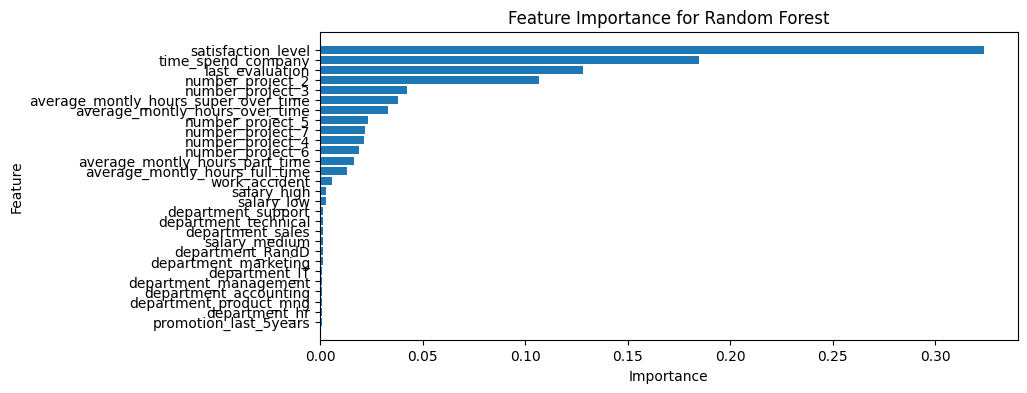

In [87]:
# Create new df with feature importaces
importance_rf_fe = clf_rf_fe.feature_importances_
feature_names_fe = X_train_fe.columns
feature_importance_df_fe = pd.DataFrame({
    'Feature': feature_names_fe,
    'Importance': importance_rf_fe
})

#Sort values
feature_importance_df_fe = feature_importance_df_fe.sort_values(by="Importance", ascending=False)

#Plot graph
plt.figure(figsize=(9, 4))
plt.barh(feature_importance_df_fe['Feature'], feature_importance_df_fe['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest')
plt.gca().invert_yaxis()
plt.show()

Key feature for Random Forest Model with Feature Engineering:
- Satisfaction level

LightGBM Model with Feature Engineering

<Axes: title={'center': 'Feature importance for LightGBM'}, xlabel='Feature importance', ylabel='Features'>

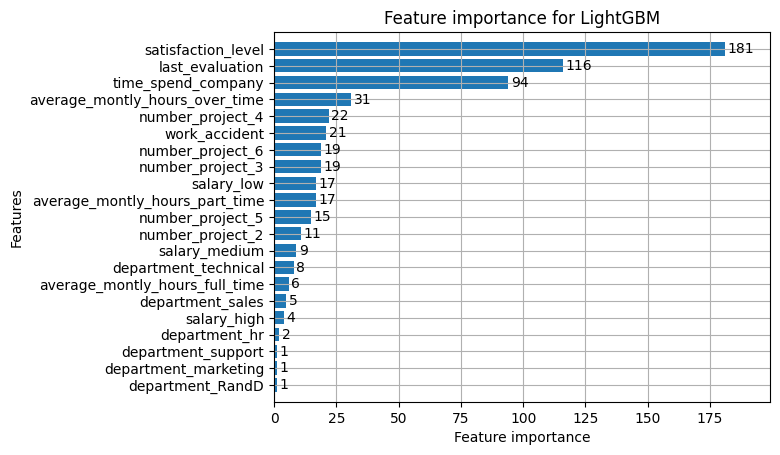

In [88]:
lgb.plot_importance(clf_lgbm_fe, height=0.8, title='Feature importance for LightGBM',\
     xlabel='Feature importance', ylabel='Features', importance_type='auto', ignore_zero=True,  grid=True)

Key features for LightGBM Model:
- Satisfaction level

### Confusion Matrices

Random Forest Model with Feature Engineering

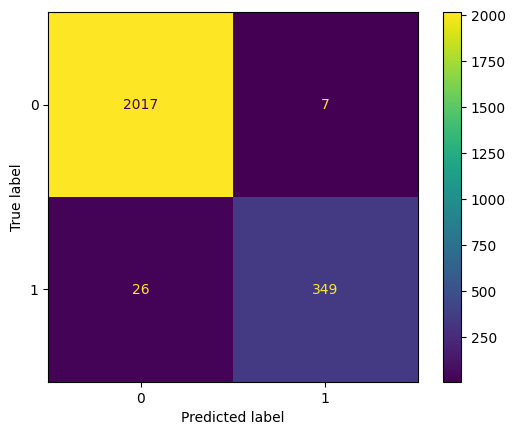

In [89]:
# Generate array of values for confusion matrix
y_test_pred_fe = clf_rf_fe.predict(X_test_fe)
cm_rf_fe = confusion_matrix(y_test_fe, y_test_pred_fe)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_fe,
                             display_labels=clf_rf_fe.classes_)
disp.plot()

LightGBM Model with Feature Engineering

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


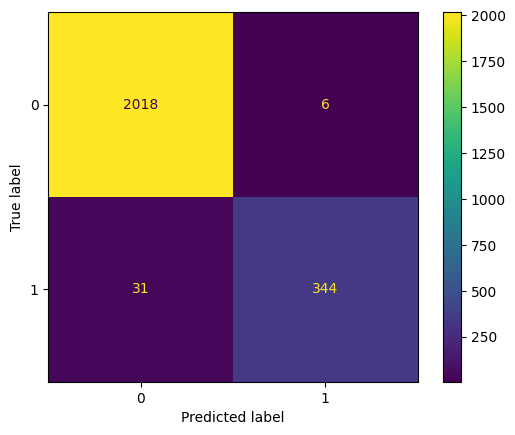

In [90]:
# Generate array of values for confusion matrix
y_test_pred_lgbm_fe = clf_lgbm_fe.predict(X_test_fe)
cm_lgbm_fe_fe = confusion_matrix(y_test_fe, y_test_pred_lgbm_fe)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm_fe_fe,
                             display_labels=clf_lgbm_fe.classes_)
disp.plot()


False Negative for LightGBM FN = 6;
False Negative for Random Forest FN = 7

The winner with Feature Engineering and in general is  LightGBM Model with results
- Precicion = 0.9828571428571429
- ROC AUC = 0.9571844532279314
- f1 = 0.9489655172413793

In [91]:
# Write pickle
write_pickle(path, clf_lgbm_fe, 'clf_lgbm_fe')

In [92]:
# Read in pickle
# clf_lgbm_fe = read_pickle(path, 'clf_lgbm_fe')

### Summary of model results

**Light GBM**

The Random Forest model achieved:
- Precicion = 0.978319783197832
- ROC AUC = 0.9481226862772997
- f1 = 0.9376623376623378


**Light GBM with Feature Engineering**

The Light GBM model achieved:
- Precicion = 0.9828571428571429
- ROC AUC = 0.9571844532279314
- f1 = 0.9489655172413793

### Modelling Conclusion

- The best two models turned out to be LightGBM and Random Forest.
- The best among them was chosen based on the test dataset's lowest number of False Negative values.
- This is important because it helps to minimize the error in determining the employees who want to leave.
- Using Feature Engineering, we were able to improve prediction results slightly.


### Dataset Conclusion

- The models and the feature importance extracted from the models confirm that employees at the company are overworked. 
- 16.6% of employees left the company.
- Among those who left, 0.4% received a promotion in the last 5 years, and 5.3% experienced an accident.
- Among those who remained, 2.0% received a promotion in the last 5 years, and 17.5% experienced an accident.
- Among employees who had a promotion in the last 5 years, 3.9% left the company.
- Among employees who did not have a promotion in the last 5 years, 16.8% left the company.
- The majority of those who left had a last performance evaluation score below 0.6 or above 0.8.
- The majority of those who left had an average monthly working hours count below 150 hours or above 250 hours.
- All employees who had more than 6 projects left the company.
- All employees who averaged more than 287 hours per month left the company.
- All employees who have worked for more than 6 years in the company remained.
- Promotion increases the satisfaction level.

### Recommendations

To retain employees, the following recommendations could be presented to the stakeholders:

* Cap the number of projects that employees can work on.
* Consider promoting employees who have been with the company for atleast four years or conduct a further investigation about why four-year tenured employees are so dissatisfied. 
* Either reward employees for working longer hours or don't require them to do so. 
* If employees need to become more familiar with the company's overtime pay policies, inform them. If the expectations around workload and time off aren't explicit, make them clear. 
* High evaluation scores should not be reserved for employees who work 195+ hours per month. Consider a proportional scale for rewarding employees who contribute effort.

Oleksandr Horenkov